# Lecture 19: Fitting and Chi2 examples

In [2]:
# Boilerplate
%matplotlib inline
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from scipy.integrate import quad

# Gaussian Example

In [3]:
mu = 10.
sig = 3.
Nsignal=1000
ssig  = np.random.normal(mu,sig,Nsignal)

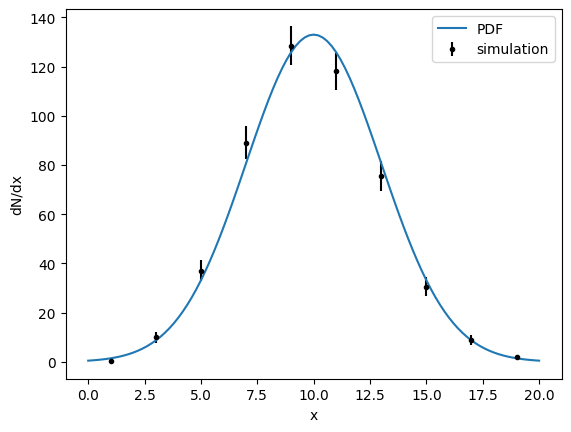

In [4]:
# Histogram them with arbitrary bin sizes
plotrange = (0.,20)
Nbins = 10
hist,bins = np.histogram(ssig,Nbins,plotrange)
hist_error = np.sqrt(hist)
hist_error = np.clip(hist_error,1.,None) # If the sqrt is 0, set it to 1.
binsize = bins[1]-bins[0]
binloc = bins[0:-1]+.5*binsize    # Move location to the middle of the bin
hist = hist/binsize               # Normalize
hist_error = hist_error/binsize   # Normalize error
plt.errorbar(binloc, hist, hist_error, fmt="k.", 
             label="simulation")
xlin = np.linspace(0.,20.,101)
pl=plt.plot(xlin,Nsignal*stats.norm.pdf(xlin,loc=mu,scale=sig),label="PDF")
xl=plt.xlabel("x")
yl=plt.ylabel("dN/dx")
leg = plt.legend()

In [5]:
# Define a chi2 function
def chi2(y,ypred,yerr=None):
    if yerr is not None:
        w=1./yerr**2         # If errors specified, the the weight is the inverse square
    else:
        w=1.
    return (w*(y-ypred)**2).sum()

In [6]:
# Let's see how well this represents the points.
pred = Nsignal*stats.norm.pdf(binloc,loc=mu,scale=sig) #Create a prediction for each bin
NDF = Nbins - 1  # Not a fit, but the normalization is a constraint
print('Chi2/NDF = ',chi2(hist,pred,hist_error)/NDF)

Chi2/NDF =  1.0110140199355004


# Linear regression

In [7]:
# Simple weighted linear regression model. Based on Numerical Recipes
def lfit(x,y,yerr=None):
    # Build up the weights, depending on whether the errors are specified
    if yerr is not None:
        w = 1/yerr**2           # If errors are given, then use inverse square for weights
        s = w.sum()             # s is the sum of weights
    else:
        w = 1.                  # If errors are not given, then the weights are all 1
        s = x.size              # The sum is the number of entries
    # Build up the standard weighted sums
    sx = (w*x).sum()
    sy = (w*y).sum()
    sxx  = (w*x**2).sum()
    sxy  = (w*x*y).sum()
    # Calculate the slope and intercept
    delta = s*sxx-sx**2
    slope = (s*sxy-sx*sy)/delta    
    intercept = (sxx*sy-sx*sxy)/delta
    return slope,intercept

In [8]:
# Define a linear function
def linfunc(x,a,b):
    return a*x+b

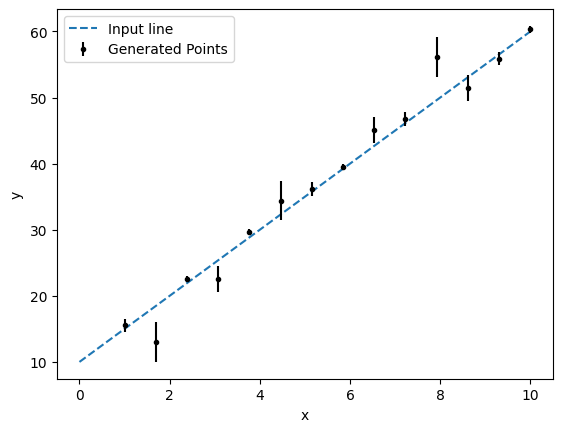

In [9]:
# fill np arrays with the data to be fit:
# build up a line and randomly distribute points around it
a_in = 5.
b_in = 10.
# plot this
xends = np.linspace(0.,10.,2) # Only need to points to draw a line
dum=plt.plot(xends,linfunc(xends,a_in,b_in),"--",label="Input line")
dum=plt.xlabel("x")
dum=plt.ylabel("y")
y_err  = np.array([1.0, 3.0, .5, 2.,.5, 3.0,1.,.5,2.,1.,3.,2.,1.,.5])
x_data = np.linspace(1.,10.,y_err.size)
y_data = np.empty(x_data.size)  # leave it empty for now
# Now distribute points around this line.  There are cuter ways to do it, but this
# is more pedagogical
for i in range(0,x_data.size):
    y_data[i] = linfunc(x_data[i],a_in,b_in)+np.random.normal(0.,y_err[i])
dum=plt.errorbar(x_data, y_data, y_err, fmt="k.", 
             label="Generated Points")
dum=plt.legend()

Fit: chi2/NDF=1.22, slope = 4.96, intercept=10.63


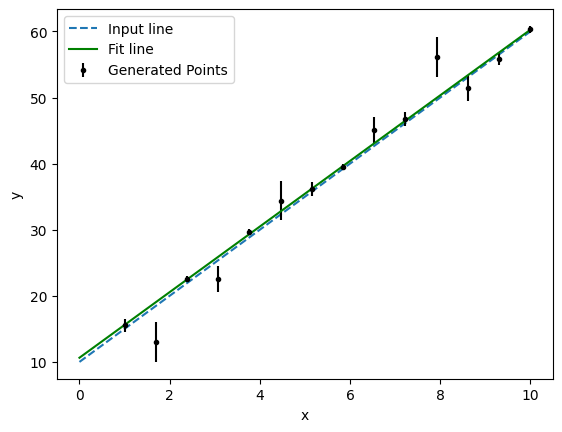

In [10]:
# Now let's fit it with our linear regression program
a_fit,b_fit = lfit(x_data,y_data,y_err)
# Calculate the Chi2/NDF
NDF=x_data.size-2
pred = linfunc(x_data,a_fit,b_fit)
chi2ndf = chi2(y_data,pred,y_err)/NDF
print("Fit: chi2/NDF=%.2f, slope = %.2f, intercept=%.2f"%(chi2ndf,a_fit, b_fit))
# Plot Everything
dum=plt.plot(xends,linfunc(xends,a_in,b_in),"--",label="Input line")
dum=plt.xlabel("x")
dum=plt.ylabel("y")
dum=plt.errorbar(x_data, y_data, y_err, fmt="k.", 
             label="Generated Points")
dum=plt.plot(xends,linfunc(xends,a_fit,b_fit),"g-",label="Fit line")
dum=plt.legend()

# Fit with generic Chi2 minimization

Fit: chi2/NDF=1.22, slope = 4.96, intercept=10.63


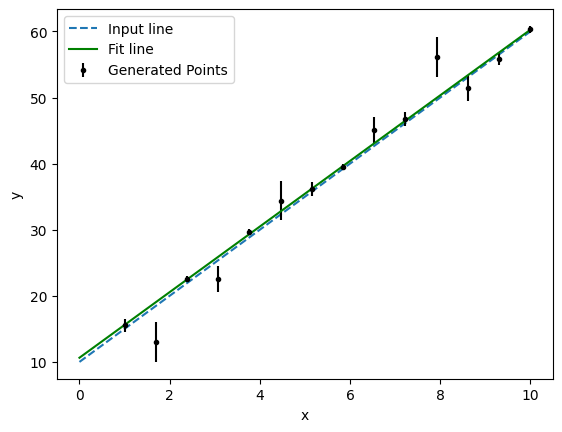

In [11]:
# Now fit with curve_fit
par, cov = optimize.curve_fit(linfunc,x_data,y_data,sigma=y_err)
a_fit=par[0]
b_fit=par[1]
# Calculate the Chi2/NDF
NDF=x_data.size-2
pred = linfunc(x_data,a_fit,b_fit)
chi2ndf = chi2(y_data,pred,y_err)/NDF
print("Fit: chi2/NDF=%.2f, slope = %.2f, intercept=%.2f"%(chi2ndf,a_fit, b_fit))
# Plot Everything
dum=plt.plot(xends,linfunc(xends,a_in,b_in),"--",label="Input line")
dum=plt.xlabel("x")
dum=plt.ylabel("y")
dum=plt.errorbar(x_data, y_data, y_err, fmt="k.", 
             label="Generated Points")
dum=plt.plot(xends,linfunc(xends,a_fit,b_fit),"g-",label="Fit line")
dum=plt.legend()

Fit: raw chi2/NDF=6.31, slope = 2.36, intercept=0.01


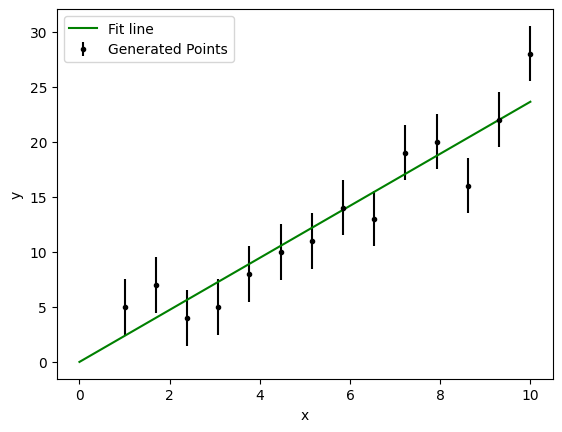

In [12]:
# Estimate errors
# Build up some new data points
y_data = np.array([5.,7.,4.,5.,8.,10.,11.,14.,13.,19.,20.,16.,22.,28.])
# Now fit it without the errors
par, cov = optimize.curve_fit(linfunc,x_data,y_data,absolute_sigma=True)
a_fit=par[0]
b_fit=par[1]
# Calculate the Chi2/NDF assuming unit errors
NDF=x_data.size-2
pred = linfunc(x_data,a_fit,b_fit)
chi2ndf = chi2(y_data,pred)/NDF
print("Fit: raw chi2/NDF=%.2f, slope = %.2f, intercept=%.2f"%(chi2ndf,a_fit, b_fit))
# Use this to estimate the error
y_err = np.full(x_data.size,np.sqrt(chi2ndf))
# Plot Everything
dum=plt.xlabel("x")
dum=plt.ylabel("y")
dum=plt.errorbar(x_data, y_data, y_err, fmt="k.", 
             label="Generated Points")
dum=plt.plot(xends,linfunc(xends,a_fit,b_fit),"g-",label="Fit line")
dum=plt.legend()

# Errors on fit parameters, both uncorrelated and correlated.

Fit: raw chi2/NDF=1.00
slope = 2.36 +- 0.24
intercept = 0.01 +- 1.48


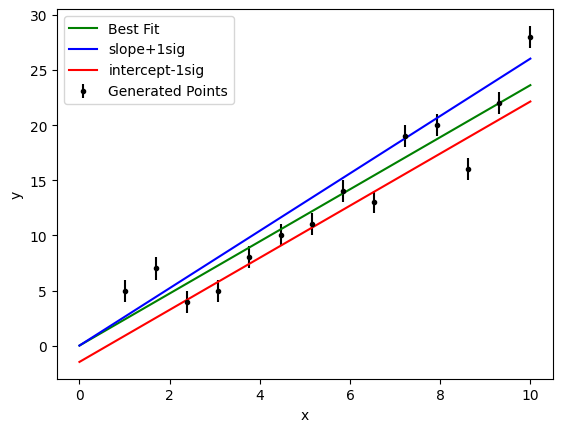

In [13]:
# Now let's check get the errors on the points
# Redo the fit with the calculated errors
par, cov = optimize.curve_fit(linfunc,x_data,y_data,sigma=y_err,absolute_sigma=True)
a_fit=par[0]
b_fit=par[1]
# Calculate the Chi2/NDF assuming unit errors
NDF=x_data.size-2
pred = linfunc(x_data,a_fit,b_fit)
chi2ndf = chi2(y_data,pred,y_err)/NDF
perr = np.sqrt(np.diag(cov))  # Error on points
print("Fit: raw chi2/NDF=%.2f"%(chi2ndf))
print("slope = %.2f +- %.2f"%(a_fit, perr[0]))
print("intercept = %.2f +- %.2f"%(b_fit, perr[1]))
# Use this to estimate the error
y_err = np.full(x_data.size,np.sqrt(chi2ndf))
# Plot Everything
dum=plt.xlabel("x")
dum=plt.ylabel("y")
dum=plt.errorbar(x_data, y_data, y_err, fmt="k.", 
             label="Generated Points")
dum=plt.plot(xends,linfunc(xends,a_fit,b_fit),"g-",label="Best Fit")
# Now plot with some errors
dum=plt.plot(xends,linfunc(xends,a_fit+perr[0],b_fit),"b-",label="slope+1sig")
dum=plt.plot(xends,linfunc(xends,a_fit,b_fit-perr[1]),"r-",label="intercept-1sig")
dum=plt.legend()

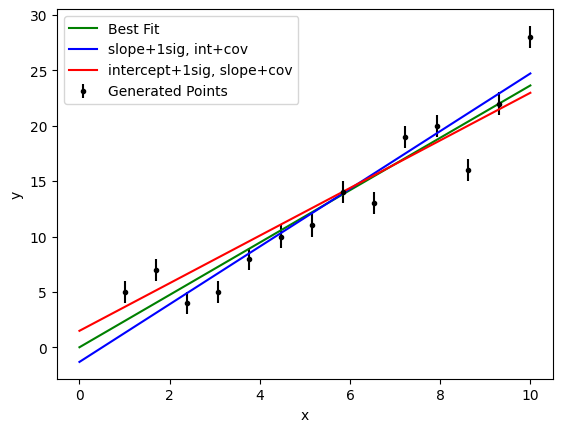

In [14]:
# Now plot with correlated errors
# Plot Everything
dum=plt.xlabel("x")
dum=plt.ylabel("y")
dum=plt.errorbar(x_data, y_data, y_err, fmt="k.", 
             label="Generated Points")
dum=plt.plot(xends,linfunc(xends,a_fit,b_fit),"g-",label="Best Fit")
# Now shift each value by 1 sigma and use the covariance matrix to get the best value of the other
a_new = a_fit + perr[0]
b_new = b_fit + perr[0]*cov[0][1]/cov[0][0]
dum=plt.plot(xends,linfunc(xends,a_new,b_new),"b-",label="slope+1sig, int+cov")
b_new = b_fit + perr[1]
a_new = a_fit + perr[1]*cov[0][1]/cov[1][1]
dum=plt.plot(xends,linfunc(xends,a_new,b_new),"r-",label="intercept+1sig, slope+cov")
dum=plt.legend()

# Testing Guassian fit as an arbitrary fit function

In [66]:
# Generate Nsignal events according to a Guassian distribution 
mu = 10.
sig = 3.
Nsignal=1000
ssig  = np.random.normal(mu,sig,Nsignal)

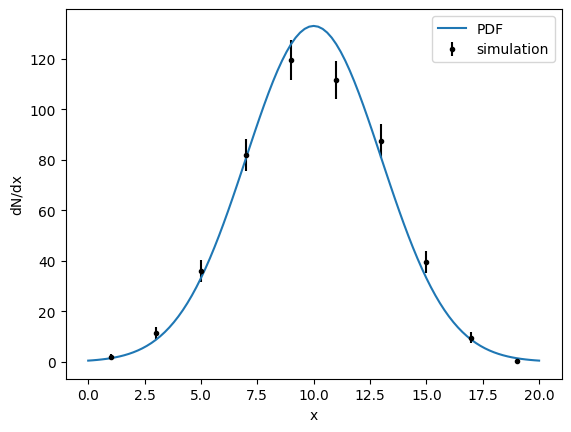

In [67]:
# Histogram them with arbitrary bin sizes
plotrange = (0.,20)
Nbins = 10
hist,bins = np.histogram(ssig,Nbins,plotrange)
hist_error = np.sqrt(hist)
hist_error = np.clip(hist_error,1.,None) # If the sqrt is 0, set it to 1.
binsize = bins[1]-bins[0]
binloc = bins[0:-1]+.5*binsize    # Move location to the middle of the bin
hist = hist/binsize               # Normalize
hist_error = hist_error/binsize   # Normalize error
plt.errorbar(binloc, hist, hist_error, fmt="k.", 
             label="simulation")
xlin = np.linspace(0.,20.,101)
pl=plt.plot(xlin,Nsignal*stats.norm.pdf(xlin,loc=mu,scale=sig),label="PDF")
xl=plt.xlabel("x")
yl=plt.ylabel("dN/dx")
leg = plt.legend()

In [68]:
# We can simply calculate all the parameters for a Guassian
Ndist = ssig.size      # Number of points
mudist = ssig.mean()   # Mean
sigdist = (ssig**2).sum()/Ndist - mudist**2 # mean of the squares - square of the mean
sigdist = np.sqrt(sigdist)                  # take the square root
print("N = %d, mu= %.1f, sig=%.1f"%(Ndist,mudist,sigdist))

N = 1000, mu= 10.0, sig=3.1


In [69]:
# But let's do it as a fit because we like to work hard.
# If I pass this function to curve_fit, it will use par[0]->par[2] for N, mu, and sig
def fit_func(x,N,mu,sig):  
    val = N*np.exp(-(x-mu)**2/2/sig**2)
    val = val/sig/np.sqrt(2*np.pi)   #Normalized
    return val

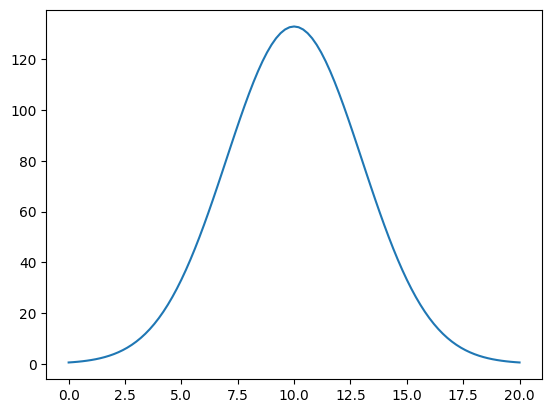

In [70]:
# test
dum=plt.plot(xlin,fit_func(xlin,Nsignal,mu,sig))

In [71]:
# Now let's fit it
par, cov = optimize.curve_fit(fit_func, binloc, hist, sigma=hist_error,absolute_sigma=True)
pred = fit_func(binloc,par[0],par[1],par[2])
NDF = Nbins-3 # 3-parameter fit.  Normalization no longer a constraint
chi2 = ((pred-hist)**2/hist_error**2).sum()/NDF
perr = np.sqrt(np.diag(cov))
print('Best fit: Chi2/NDF=%.3f'%(chi2))
print('    N=%.1f +- %1f'%(par[0],perr[0]))
print('    mu=%.2f +- %2f'%(par[1],perr[1]))
print('    sig=%.3f +- %3f'%(par[2],perr[2]))


Best fit: Chi2/NDF=1.670
    N=988.2 +- 31.451837
    mu=9.93 +- 0.098999
    sig=3.074 +- 0.065844


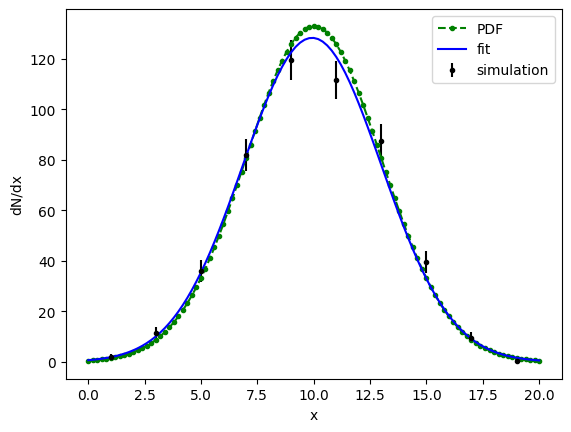

In [72]:
# Plot all three
plt.errorbar(binloc, hist, hist_error, fmt="k.", 
             label="simulation")
xlin = np.linspace(0.,20.,101)
pl=plt.plot(xlin,Nsignal*stats.norm.pdf(xlin,loc=mu,scale=sig),"g.--",label="PDF")
pl=plt.plot(xlin,fit_func(xlin,par[0],par[1],par[2]),"b",label="fit")
xl=plt.xlabel("x")
yl=plt.ylabel("dN/dx")
leg = plt.legend()

# Signal and linear background fit

In [84]:
# Returns N 1-D random numbesr based on the function myfunc, in the range xlo to xhi
# funcmax is the maximum value of funcmax
#
def mydist(func,N=1,xlo=0.,xhi=1.,funcmax=1.):
    s = np.empty(N)         # Generate an empty vector N long
    for i in range(0,N):   
        while (True):       # Loop until we find a "good" number
            x = np.random.uniform(xlo,xhi)
            if(func(x)>=funcmax*np.random.uniform()):
                break       # Exit the generation loop
        s[i]=x
    return s

In [85]:
# linear background
def backfunc(x):
    return a_background*x+b_background # Note, these are global variables

In [96]:
#Generate a signal and linear background
# Gaussian signal
N_signal = 200
mu_signal = 30.
sig_signal = 1.5
# (Unnormalized!) Linear background
N_background = 1000
a_background = -2.   # slope of background
b_background = 120.   # intercept of background
# Generate the signal
sig = np.random.normal(mu_signal,sig_signal,N_signal)
# Generate the background
back = mydist(backfunc,N_background,0.,50.,b_background)

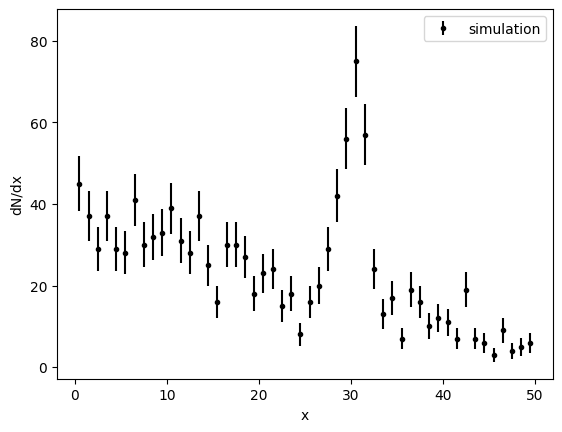

In [97]:
# Combine the samples and histogram
data = np.append(sig,back) # Note, we're just tacking the signal on the end of the background
plotrange = (0.,50)
Nbins = 50
hist,bins = np.histogram(data,Nbins,plotrange)
hist_error = np.sqrt(hist)
hist_error = np.clip(hist_error,1.,None) # If the sqrt is 0, set it to 1.
binsize = bins[1]-bins[0]
binloc = bins[0:-1]+.5*binsize    # Move location to the middle of the bin
hist = hist/binsize               # Normalize
hist_error = hist_error/binsize   # Normalize error
plt.errorbar(binloc, hist, hist_error, fmt="k.", 
             label="simulation")
xl=plt.xlabel("x")
yl=plt.ylabel("dN/dx")
leg = plt.legend()

In [98]:
# Linear + gaussian fit function with 5 parameters
def sigfit(x,a,b,N,mu,sig):
    lin = a*x+b
    gauss = N*stats.norm.pdf(x,loc=mu,scale=sig)
    return lin+gauss

In [99]:
# Now let's fit it
# Guess
# guess = np.array([40.,-1.,10.,30.,1.])
guess = None
par, cov = optimize.curve_fit(sigfit, binloc, hist, 
            p0=guess,sigma=hist_error,absolute_sigma=True)
pred = sigfit(binloc,par[0],par[1],par[2],par[3],par[4])
NDF = Nbins-5 # 5-parameter fit.  Normalization no longer a constraint
chi2 = ((pred-hist)**2/hist_error**2).sum()/NDF
perr = np.sqrt(np.diag(cov))
print('Best fit: Chi2/NDF=%.3f'%(chi2))
print('    a=%.1f +- %1f'%(par[0],perr[0]))
print('    b=%.2f +- %2f'%(par[1],perr[1]))
print('    N=%.1f +- %1f'%(par[2],perr[2]))
print('    mu=%.2f +- %2f'%(par[3],perr[3]))
print('    sig=%.3f +- %3f'%(par[4],perr[4]))

Best fit: Chi2/NDF=1.549
    a=-0.6 +- 0.038448
    b=34.84 +- 1.426241
    N=186.7 +- 17.871501
    mu=30.25 +- 0.140629
    sig=1.318 +- 0.127140


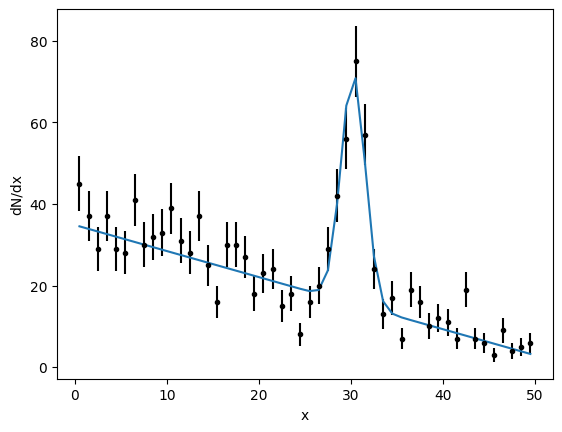

In [100]:
# Plot them both
plt.errorbar(binloc, hist, hist_error, fmt="k.", 
             label="simulation")
plt.plot(binloc,pred,label="best fit")
xl=plt.xlabel("x")
yl=plt.ylabel("dN/dx")

# Log likelihood fit

In [101]:
# Initialize the random seed.  As long as this remainst the same, the output will remain the same
np.random.seed(57884776)

In [102]:
# Define a chi2 function
def chi2(y,ypred,yerr=None):
    if yerr is not None:
        w=1./yerr**2         # If errors specified, the the weight is the inverse square
    else:
        w=1.
    return (w*(y-ypred)**2).sum()

In [103]:
# Returns N 1-D random numbesr based on the function myfunc, in the range xlo to xhi
# funcmax is the maximum value of funcmax. Modify it to take a function with arguments
#
def mydist(func,N=1,xlo=0.,xhi=1.,funcmax=1.,pars=None):
    s = np.empty(N)         # Generate an empty vector N long
    for i in range(0,N):   
        while (True):       # Loop until we find a "good" number
            x = np.random.uniform(xlo,xhi)
            if(func(x,*pars)>=funcmax*np.random.uniform()):
                break       # Exit the generation loop
        s[i]=x
    return s

In [104]:
# Test distribution function
# Unlike our previous function, this one is not normalized
#
def distfunc_unnorm(x,a,b):
    val = (x+a*x**2)*np.exp(-b*x)  
    return val

In [105]:
# Normalize this.  
def distfunc(x,a,b):
    # Integrate the function every time it's called. Note: this is a resource hog, but computers are cheap these days
    integral = quad(distfunc_unnorm,xlo,xhi,args=(a,b))  # scipy.integrate.quad -> This returns the integral and its error
    integral = integral[0]
    return (distfunc_unnorm(x,a,b)/integral)

In [106]:
# Plot a histogram of my test function
Nsignal = 20
xlo=0.
xhi=20.
plotrange = (xlo,xhi)
Nbins = 20
# Put input values into the function
a_in=2.
b_in=.4
pars_in=np.array([a_in,b_in])
# We must now numerically calculate the maximum value and the integral of this function.
# Calculate the maximum value
x = np.linspace(plotrange[0],plotrange[1],10000)
y = distfunc(x,*pars_in)
funcmax = y.max()
# Check the normalization
integral = quad(distfunc,xlo,xhi,args=(a_in,b_in))  # This returns  the integeral and the error on the integral
integral = integral[0]
print("Maximum value of function = %.2f, Integral = %.2f"%(funcmax,integral))

Maximum value of function = 0.11, Integral = 1.00


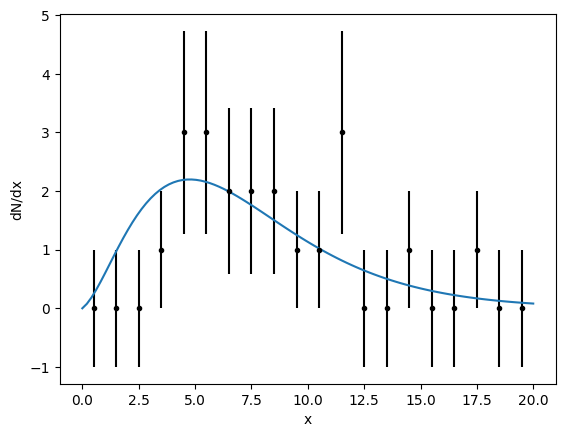

In [107]:
# Now we're going to generate a distribution according to this function
#
ssig = mydist(distfunc,Nsignal,xlo=xlo,xhi=xhi,funcmax=funcmax,pars=pars_in)
# Now do everything the way we did it before
# Number of bins fixed at the range
hist,bins = np.histogram(ssig,Nbins,plotrange)
hist_error = np.sqrt(hist)
hist_error = np.clip(hist_error,1.,None) # If the sqrt is 0, set it to 1.
binsize = bins[1]-bins[0]
binloc = bins[0:-1]+.5*binsize    # Move location to the middle of the bin
hist = hist/binsize               # Normalize
hist_error = hist_error/binsize   # Normalize error
plt.errorbar(binloc, hist, hist_error, fmt="k.", 
             label="simulation")
xlin = np.linspace(xlo,xhi,100)
pl=plt.plot(xlin,Nsignal*distfunc(xlin,*pars_in))
lx = plt.xlabel("x")
ly = plt.ylabel("dN/dx")

In [108]:
# Define our fitting function to be the normalized d
# istribution function times the number of events.
def fitfunc(x,a,b):
    return distfunc(x,a,b)*Nsignal

In [109]:
# Estimate errors
# guesstimate values
a_guess = 1
b_guess = .5
p0 = np.array([a_guess,b_guess])
par, cov = optimize.curve_fit(fitfunc,binloc,hist,p0=p0,sigma=hist_error,absolute_sigma=True)
a_fit=par[0]
b_fit=par[1]
perr = np.sqrt(np.diag(cov))  # Error on points
a_err=perr[0]
b_err=perr[1]

Fit: 	Chi2/NDF=0.38
 	a = 3048193.53 +- 18282525194399.74
 	b=0.34 +- 0.11



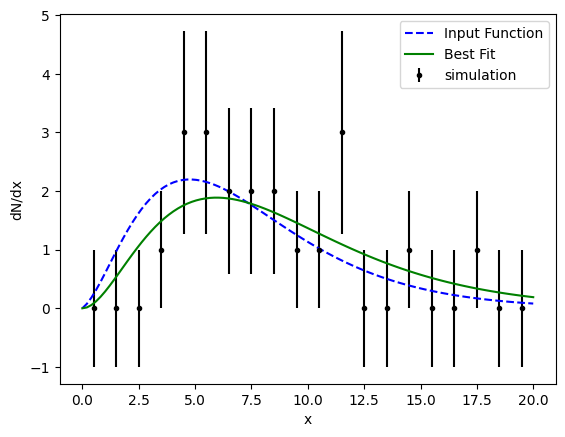

In [110]:
NDF=bins.size-3
pred = fitfunc(binloc,a_fit,b_fit)
chi2ndf = chi2(pred,hist,hist_error)/NDF
print("Fit: \tChi2/NDF=%.2f\n \ta = %.2f +- %.2f\n \tb=%.2f +- %.2f\n"%(chi2ndf,a_fit, a_err,b_fit,b_err))
# Plot Everything
plt.errorbar(binloc, hist, hist_error, fmt="k.", 
             label="simulation")
xlin = np.linspace(xlo,xhi,100)
# Plot the input function
pl=plt.plot(xlin,distfunc(xlin,a_in,b_in)*Nsignal,"b--",label="Input Function")
pl=plt.plot(xlin,fitfunc(xlin,a_fit,b_fit),"g-",label="Best Fit")
lx = plt.xlabel("x")
ly = plt.ylabel("dN/dx")
dum = plt.legend()

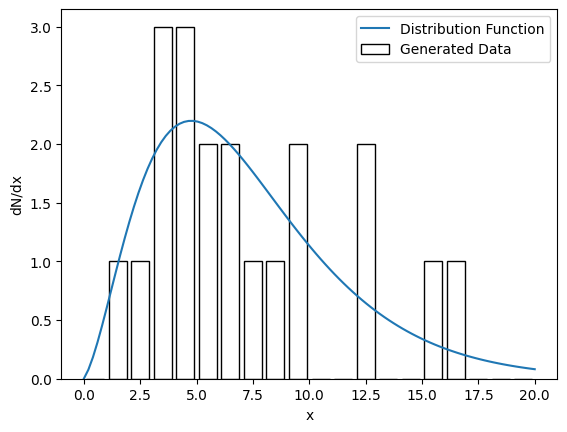

In [118]:
# Generate a distribution according to the function
Nsignal = 20
ssig = mydist(distfunc,Nsignal,xlo=xlo,xhi=xhi,funcmax=funcmax,pars=pars_in)
# Be careful with the number of bins and bin widths!
Nbins = int(xhi-xlo)
# Now do everything the way we did it before
hist,bins = np.histogram(ssig,Nbins,plotrange)
hist_error = np.sqrt(hist)
hist_error = np.clip(hist_error,1.,None) # If the sqrt is 0, set it to 1.
binsize = bins[1]-bins[0]
binloc = bins[0:-1]+.5*binsize    # Move location to the middle of the bin
# Don't normalize and errors are irrelevant now!
plt.bar(binloc, hist, fill=False,              label="Generated Data")
xlin = np.linspace(xlo,xhi,100)
pl=plt.plot(xlin,Nsignal*distfunc(xlin,*pars_in),label="Distribution Function")
leg = plt.legend()
lx = plt.xlabel("x")
ly = plt.ylabel("dN/dx")

In [119]:
# Define a log liklihood function
def loglikelihood(pars):
    x = binloc
    n = hist
    ypred = fitfunc(x,*pars)
    #print(ypred)
    ll = -(n*np.log(ypred)).sum() 
    return(ll)   

In [120]:
ll_fit= optimize.minimize(loglikelihood,np.array([1.,.5]))#,bounds=[(.1,2000.),(.2,.6)])
print(ll_fit)
pars_fit=ll_fit['x']
print("a = %.2f , b = %.3f "%(pars_fit[0],pars_fit[1]))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -5.752773799391141
        x: [ 1.422e+03  4.054e-01]
      nit: 38
      jac: [-2.384e-07 -6.199e-06]
 hess_inv: [[ 2.376e+02 -1.860e-01]
            [-1.860e-01  4.333e-03]]
     nfev: 159
     njev: 53
a = 1421.77 , b = 0.405 


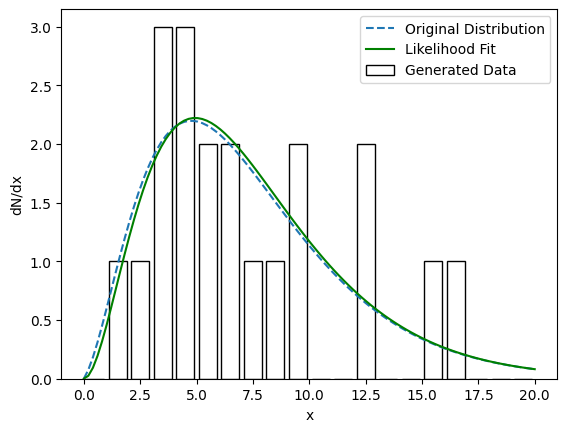

In [121]:
# Don't normalize and errors are irrelevant now
plt.bar(binloc, hist, fill=False,              label="Generated Data")
xlin = np.linspace(xlo,xhi,100)
pl=plt.plot(xlin,Nsignal*distfunc(xlin,*pars_in),"--",label="Original Distribution")
pl=plt.plot(xlin,fitfunc(xlin,*pars_fit),"g-",label="Likelihood Fit")
lx = plt.xlabel("x")
ly = plt.ylabel("dN/dx")
dum = plt.legend()

In [122]:
# Use the Hessian matrix to calculate the errors
import numdifftools as ndt

Hfun = ndt.Hessian(loglikelihood,full_output=True)  # Define it in terms of our -likelihood function
hessian_ndt,info = Hfun(ll_fit.x)                   # Calculate the hessian matrix, starting from our fit results.

print (hessian_ndt)

[[ 5.99297463e-11 -4.68816609e-06]
 [-4.68816609e-06  3.03905789e+02]]


In [123]:
hessian_inv = np.linalg.inv(hessian_ndt)            # Invert matrix
ll_fit_errors = np.sqrt(np.diag(hessian_inv))       # The errors are the square root of the diagonal

In [124]:
print('a = %.1f +- %.1f'%(ll_fit.x[0],ll_fit_errors[0]))
print('b = %.3f +- %.3f'%(ll_fit.x[1],ll_fit_errors[1]))

a = 1421.8 +- 129253.1
b = 0.405 +- 0.057
